In [2]:
import pydicom
# import SimpleITK as sitk
import pandas as pd 
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import cv2
import tensorflow as tf
from pathlib import Path
import pathlib
# %matplotlib inline

In [3]:
path = Path("data/content/")

In [4]:
df = pd.read_csv(path / "labels.csv")
df.drop('Unnamed: 0', axis=1, inplace=True)
df.head(100)

,SOPInstanceUID,Label
0,1.2.246.512.1002.1058214001.1267878993.1650415...,normal
1,2.25.4669378111734520225376815262123197003,normal
2,1.2.246.512.1.2.0.4.397070732735579.1755416012...,normal
3,2.25.253986991488355213316410237483051286906,normal
4,2.25.61269522713157549205486841880699641492,normal
...,...,...
95,2.25.95301085161359068904812759023575525475,abnormal
96,1.2.246.512.1.2.0.4.120699027219781.1785915121...,normal
97,2.25.40752906400399014196156034336759107300,normal
98,1.2.246.512.1002.3876311061.1152214383.7426756...,normal


In [5]:
len(df.loc[df['Label'] == "abnormal"])

49

In [6]:
images, labels = list(), list()
for idx, (sop, lbl) in df.iterrows():
    ds = pydicom.dcmread(path / f"DICOM/{sop}.dcm")
    img = ds.pixel_array
    cropped = img[400:1300 , 500:2500]
    images.append(cv2.resize(cropped, (2000, 900)) / 255.)
    labels.append(1 if lbl == "abnormal" else 0)

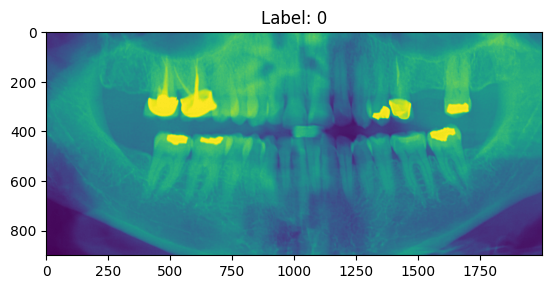

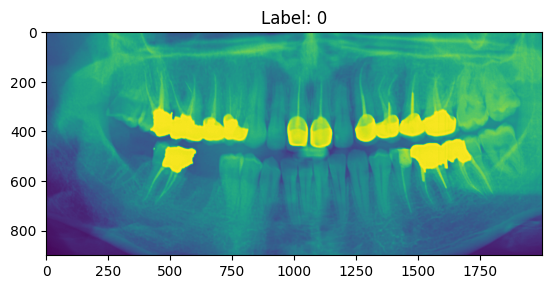

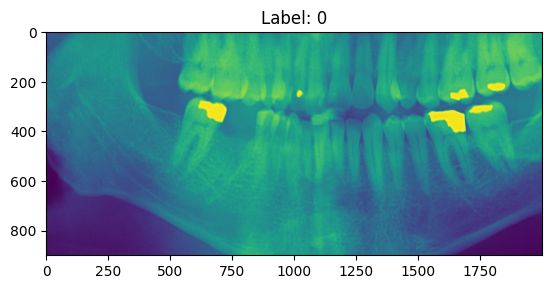

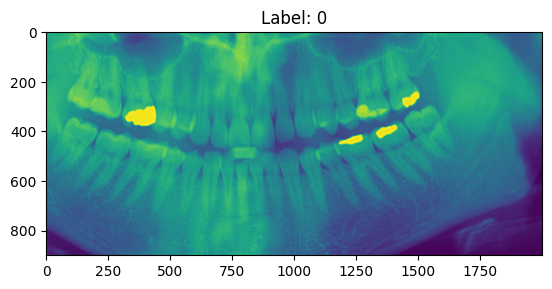

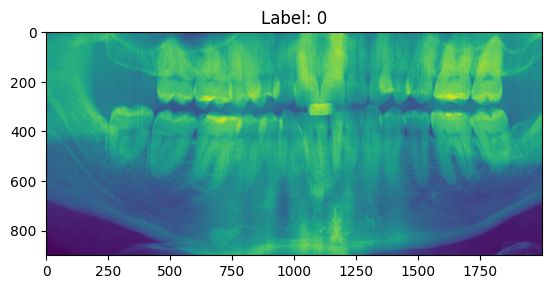

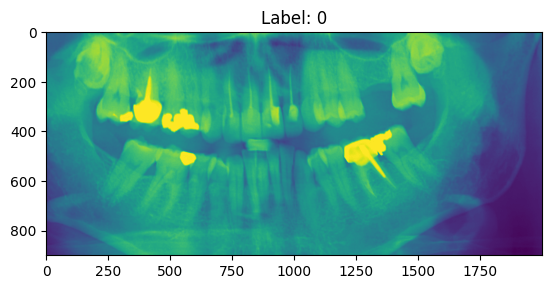

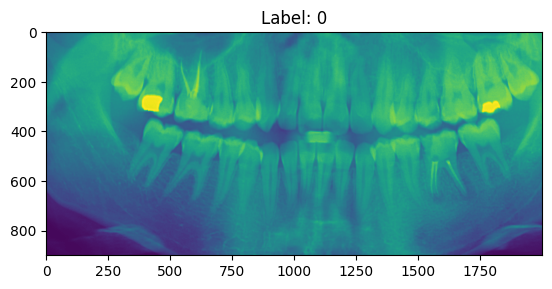

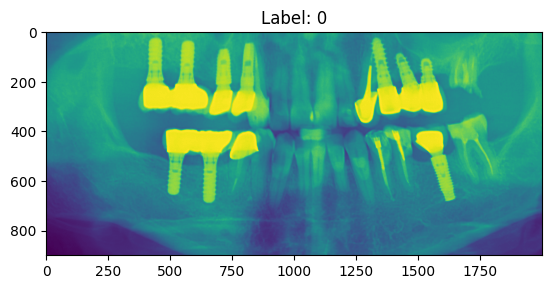

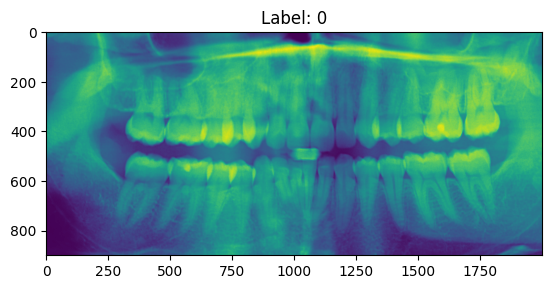

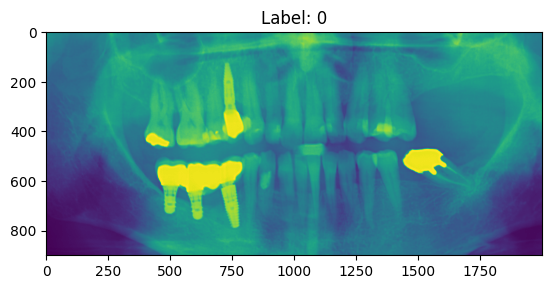

In [7]:
for i in range(10):
    plt.imshow(images[i])
    plt.title(f"Label: {labels[i]}")
    plt.show()

In [8]:
images = np.array(images)
labels = np.array(labels)

In [9]:
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.33, random_state=42)

In [10]:
inputs = tf.keras.layers.Input(shape=(224, 224, 1))
x = tf.keras.layers.Conv2D(3, 1, 1, padding='same')(inputs)
base_model = tf.keras.applications.ResNet50(input_shape=(224, 224, 3),
                                               include_top=False,
                                               weights='imagenet')
base_model.trainable = False
x = base_model(x)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = tf.keras.layers.Dense(1)(x)
model = tf.keras.Model(inputs, outputs)

2023-05-20 22:27:22.252109: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2023-05-20 22:27:23.892056: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-20 22:27:23.893345: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1561] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce GTX 1650 computeCapability: 7.5
coreClock: 1.515GHz coreCount: 14 deviceMemorySize: 3.82GiB deviceMemoryBandwidth: 178.84GiB/s
2023-05-20 22:27:23.895122: W tensorflow/stream_executor/platform/default/dso_loader.cc:55] Could not load dynamic library 'libcudart.so.10.1'; dlerror: libcudart.so.10.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/lib/python3.8/dist-packages/cv2/../../lib64:
2023-05-20 22:27:23.896047: W tensorflow/strea

Exception: URL fetch failure on https://storage.googleapis.com/tensorflow/keras-applications/resnet/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5: 403 -- Forbidden

In [ ]:
base_learning_rate = 0.0001

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['acc', tf.keras.metrics.Precision(),
                       tf.keras.metrics.Recall(),
                       tf.keras.metrics.AUC(),])

In [ ]:
res = model.fit(x=X_train, y=y_train, epochs=10, validation_split=0.3)

Epoch 1/10
8/8 [==============================] - 109s 12s/step - loss: 1.1143 - acc: 0.4538 - precision_1: 0.1379 - recall_1: 0.8000 - auc_1: 0.6308 - val_loss: 0.8921 - val_acc: 0.6311 - val_precision_1: 0.0556 - val_recall_1: 0.3333 - val_auc_1: 0.5206
Epoch 2/10
8/8 [==============================] - 81s 10s/step - loss: 0.8007 - acc: 0.6387 - precision_1: 0.0704 - recall_1: 0.2000 - auc_1: 0.4560 - val_loss: 0.5906 - val_acc: 0.8932 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00 - val_auc_1: 0.4648
Epoch 3/10
8/8 [==============================] - 77s 10s/step - loss: 0.5580 - acc: 0.8151 - precision_1: 0.1481 - recall_1: 0.1600 - auc_1: 0.5557 - val_loss: 0.4121 - val_acc: 0.9417 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00 - val_auc_1: 0.4897
Epoch 4/10
8/8 [==============================] - 79s 10s/step - loss: 0.4620 - acc: 0.8824 - precision_1: 0.2857 - recall_1: 0.0800 - auc_1: 0.5325 - val_loss: 0.3181 - val_acc: 0.9417 - val_precision_1: 0.0000e+00 - 

In [ ]:
model.save("model.h5")

In [ ]:
loaded_model = tf.keras.models.load_model("model.h5")
loaded_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 1)]     0         
                                                                 
 conv2d_1 (Conv2D)           (None, 224, 224, 3)       6         
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d_1   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_1 (Dropout)         (None, 2048)              0         
                                                                 
 dense_1 (Dense)             (None, 1)                 2049      
                                                           

In [ ]:
loaded_model.evaluate(x=X_test, y=y_test)

6/6 [==============================] - 17s 2s/step - loss: 0.3557 - acc: 0.8929 - precision_1: 0.0000e+00 - recall_1: 0.0000e+00 - auc_1: 0.5000


[0.35569828748703003, 0.8928571343421936, 0.0, 0.0, 0.5]